<a href="https://colab.research.google.com/github/algorithmiaio/model-deployment/blob/master/tensorflow_classify_text_deploy_algorithmia/tensorflow_classify_text_deploy_algorithmia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Classifying Text with Tensorflow & Deploying with Algorithmia

This notebook aims to show how you can deploy a tensorflow model to Algorithmia.
You can also deploy this model from Google Colab! Just click on the "Open in Colab" badge above.

## 1.1 Setup virtual environment & install packages

Setup a virtual environment using Python 3.6 (conda works great)

Pip install the packages in the cell below, in your environment.

If the notebook doesn't work with the packages above, please create an issue [here](https://github.com/algorithmiaio/model-deployment/issues).

**(Optional for Google Colab):** Please keep in mind that Google Colab constantly updates their default packages.

Please pip install the following packages if you're on Google Colab:

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install tensorflow==1.12.2 algorithmia==1.2.1 jupyter==1.0.0 gitpython==2.1.11 matplotlib==3.0.2 urllib3==1.24.3 retry==0.9.2 numpy==1.16.1

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 1.2 Imports for Tensorflow

Let's now import everything we need to download our dataset and train our model:

In [3]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import numpy as np
from retry import retry

print("Installed Tensorflow version: {}".format(tf.__version__))

/Users/besirkurtulmus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Installed Tensorflow version: 1.12.2


## 2. Dowload the IMDB dataset

Let's download the IMDB dataset using the keras built-in datasets tool:

In [4]:
imdb = keras.datasets.imdb

print("Downloading the IMDB dataset...")

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

print("Download complete!")

Download complete!


## 3. Explore the data

Let's see how many reviews we have in our dataset:

In [5]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


Let's preview the first entry in the dataset:

In [6]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Before you can start training, you need to make sure all of your reviews are vectorized. Fortunately, our dataset is already vectorized.

Let's also check the vector lengths of the first two reviews:

In [7]:
print("First vector length: {}".format(len(train_data[0])))
print("Second vector length: {}".format(len(train_data[1])))

First vector length: 218
Second vector length: 189


As you can see, they're not fixed-length. This is an issue, as most models can't handle variable-length vectors.

We need to later fix them to a static size.

## 4. Convert the integers back to words

Before we fix the lengths of vectors, let's first confirm that these vectors are indeed movie reviews.

Our dataset comes with a word index. We can use this to decode movie vectors.

Let's write a function called `decode_review(text)` that can decode vectors back into movie reviews.

In [8]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

Now let's check the texrt version of the first review:

In [9]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 5. Prepare the data

Now it's time to create the training & testing datasets.

We're also going to resize our vectors up to 256. We'll add `<PAD>` tokens to fill them up:

In [10]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

Let's now confirm the new vector sizes:

In [11]:
print("First vector length: {}".format(len(train_data[0])))
print("Second vector length: {}".format(len(train_data[1])))

First vector length: 256
Second vector length: 256


Let's also confirm that the first vector has been padded:

In [12]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

As you can see above, the vectors has been padded w/ zeros.

## 6. Build the model

Now we can define our model layers:

In [13]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


Let's select our optimizer, loss function & metric:

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Our model is now ready to train.

## 7. Create a validation set

We need to create a validation dataset that will be used for training:

In [15]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 8. Train the model

We can now train our model:

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

/Users/besirkurtulmus/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 42us/step - loss: 0.6916 - acc: 0.6328 - val_loss: 0.6895 - val_acc: 0.7236
Epoch 2/40
15000/15000 [==============================] - 0s 21us/step - loss: 0.6858 - acc: 0.7368 - val_loss: 0.6816 - val_acc: 0.6923
Epoch 3/40
15000/15000 [==============================] - 0s 19us/step - loss: 0.6736 - acc: 0.7365 - val_loss: 0.6659 - val_acc: 0.7446
Epoch 4/40
15000/15000 [==============================] - 0s 20us/step - loss: 0.6519 - acc: 0.7526 - val_loss: 0.6419 - val_acc: 0.7723
Epoch 5/40
15000/15000 [==============================] - 0s 21us/step - loss: 0.6204 - acc: 0.7916 - val_loss: 0.6081 - val_acc: 0.7822
Epoch 6/40
15000/15000 [==============================] - 0s 20us/step - loss: 0.5805 - acc: 0.8099 - val_loss: 0.5692 - val_acc: 0.7945
Epoch 7/40
15000/15000 [==============================] - 0s 21us/step - loss: 0.5356 - acc: 0.8279 - val_loss: 0.5275 - val_acc

## 9. Evaluate the model

Let's now get the loss & accuracy of our model using our test dataset:

In [17]:
results = model.evaluate(test_data, test_labels)

print("Loss: {}, Accuracy: {}".format(results[0], results[1]))

25000/25000 [==============================] - 0s 13us/step
Loss: 0.32303804344177245, Accuracy: 0.87292


## 10. Create a graph of accuracy and loss over time

Let's also visually see the how our model has trained over time.

We'll graph two things:

* Training and validation loss
* Training and validation accuracy

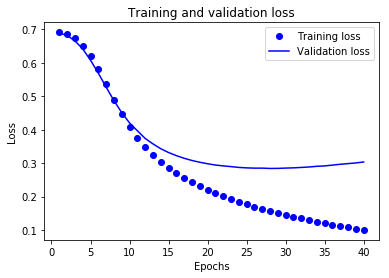

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

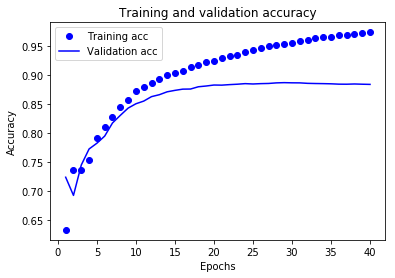

In [19]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 11. Deployment

### Algorithmia credentials

If you haven't already, you can signup on Algorithmia [here](https://algorithmia.com/signup?utm_medium=jupyter-notebook&utm_source=jupyter-notebook).
When creating your API key, make sure to enable `Read & Write` for `Data Access` and enable `Management APIs`.

In [24]:
%run -i "deploy.py" -k "simXXXXXXXXXXXXXXXXXXXXXXXXX" -u "b" -a "movie_review_sentiment" -m "model.py" -d "model_requirements.txt"

Algorithm namepace: b/movie_review_sentiment
Algorithm URL: https://algorithmia.com/algorithms/b/movie_review_sentiment
Pushing source code upstream, uploading model file & compiling algorithm...
Algorithm Source Code is available at: https://algorithmia.com/algorithms/b/movie_review_sentiment/source
Testing new compiled algorithm via API endpoint...
Test complete!
Publishing and deploying algorithm...
Algorithm has been deployed!


You just successfully deployed your Tensorflow model!

You can call this API endpoint from anywhere: your mobile app, your website, and more...

### License

This notebook is based on the guide from: https://www.tensorflow.org/tutorials/keras/basic_text_classification

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.